In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import kpss



In [5]:
base_path = '/Users/freddiekiessling/Desktop/Data_Science/PSTAT_277B/ZM1_ZL1_ZS1'
def load_and_process_soybean_data(base_path):

    # File paths for each commodity and frequency
    oil_day_path = f'{base_path}/CBOT_DL_ZL1!, 1D.csv'
    oil_hour_path = f'{base_path}/CBOT_DL_ZL1!, 60.csv'  # 60 minutes = 1 hour
    oil_min_path = f'{base_path}/CBOT_DL_ZL1!, 1.csv'
    oil_sec_path = f'{base_path}/CBOT_DL_ZL1!, 1S.csv'

    meal_day_path = f'{base_path}/CBOT_DL_ZM1!, 1D.csv'
    meal_hour_path = f'{base_path}/CBOT_DL_ZM1!, 60.csv'
    meal_min_path = f'{base_path}/CBOT_DL_ZM1!, 1.csv'
    meal_sec_path = f'{base_path}/CBOT_DL_ZM1!, 1S.csv'

    soybeans_day_path = f'{base_path}/CBOT_DL_ZS1!, 1D.csv'
    soybeans_hour_path = f'{base_path}/CBOT_DL_ZS1!, 60.csv'
    soybeans_min_path = f'{base_path}/CBOT_DL_ZS1!, 1.csv'
    soybeans_sec_path = f'{base_path}/CBOT_DL_ZS1!, 1S.csv'

    # Load all data
    # Soybean Oil
    soy_oil_day = pd.read_csv(oil_day_path)
    soy_oil_hour = pd.read_csv(oil_hour_path)
    soy_oil_min = pd.read_csv(oil_min_path)
    soy_oil_sec = pd.read_csv(oil_sec_path)

    # Soybean Meal
    soy_meal_day = pd.read_csv(meal_day_path)
    soy_meal_hour = pd.read_csv(meal_hour_path)
    soy_meal_min = pd.read_csv(meal_min_path)
    soy_meal_sec = pd.read_csv(meal_sec_path)

    # Soybeans
    soy_beans_day = pd.read_csv(soybeans_day_path)
    soy_beans_hour = pd.read_csv(soybeans_hour_path)
    soy_beans_min = pd.read_csv(soybeans_min_path)
    soy_beans_sec = pd.read_csv(soybeans_sec_path)

    # Parse timestamps for all dataframes
    for df in [soy_oil_day, soy_oil_hour, soy_oil_min, soy_oil_sec,
               soy_meal_day, soy_meal_hour, soy_meal_min, soy_meal_sec,
               soy_beans_day, soy_beans_hour, soy_beans_min, soy_beans_sec]:
        df['time'] = pd.to_datetime(df['time'], unit='s')

    return (soy_oil_day, soy_oil_hour, soy_oil_min, soy_oil_sec,
            soy_meal_day, soy_meal_hour, soy_meal_min, soy_meal_sec,
            soy_beans_day, soy_beans_hour, soy_beans_min, soy_beans_sec)


In [6]:
def calculate_crush_spread(soy_meal_price, soy_oil_price, soybean_price):
    return (soy_meal_price * 0.022 + soy_oil_price * 0.11) - soybean_price

def crush_spread_calculations_per_data_time(soy_beans_day, soy_meal_day, soy_oil_day,
                                          soy_beans_hour, soy_meal_hour, soy_oil_hour,
                                          soy_beans_min, soy_meal_min, soy_oil_min,
                                          soy_beans_sec, soy_meal_sec, soy_oil_sec):
    """
    Calculate crush spreads for all time frequencies.
    """
    # For daily data
    crush_spread_day = pd.DataFrame({
        'time': soy_beans_day['time'],
        'crush_spread': calculate_crush_spread(
            soy_meal_day['close'],
            soy_oil_day['close'],
            soy_beans_day['close']
        )
    })

    # For hourly data
    crush_spread_hour = pd.DataFrame({
        'time': soy_beans_hour['time'],
        'crush_spread': calculate_crush_spread(
            soy_meal_hour['close'],
            soy_oil_hour['close'],
            soy_beans_hour['close']
        )
    })

    # For minute data
    crush_spread_min = pd.DataFrame({
        'time': soy_beans_min['time'],
        'crush_spread': calculate_crush_spread(
            soy_meal_min['close'],
            soy_oil_min['close'],
            soy_beans_min['close']
        )
    })

    # For second data
    crush_spread_sec = pd.DataFrame({
        'time': soy_beans_sec['time'],
        'crush_spread': calculate_crush_spread(
            soy_meal_sec['close'],
            soy_oil_sec['close'],
            soy_beans_sec['close']
        )
    })

    # Set time as index for easier time series analysis
    crush_spread_day.set_index('time', inplace=True)
    crush_spread_hour.set_index('time', inplace=True)
    crush_spread_min.set_index('time', inplace=True)
    crush_spread_sec.set_index('time', inplace=True)
    
    return crush_spread_day, crush_spread_hour, crush_spread_min, crush_spread_sec

In [7]:
def plot_commodity_timeseries(data_dict, commodity_name):
    """
    Plot time series for a commodity across all timeframes
    """
    fig, axes = plt.subplots(1, 4, figsize=(24, 5))  # Changed to 4 subplots
    fig.suptitle(f'{commodity_name} Price Time Series', fontsize=16)
    timeframes = ['sec', 'min', 'hour', 'day']  # Added 'hour'
    titles = ['Second Data', 'Minute Data', 'Hourly Data', 'Daily Data']  # Added 'Hourly Data'
    
    for ax, timeframe, title in zip(axes, timeframes, titles):
        data_dict[timeframe].plot(y='close', ax=ax)
        ax.set_title(title)
        ax.set_xlabel('Time')
        ax.set_ylabel('Price')
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
def plot_crush_spreads(crush_spreads):
    """
    Plot crush spreads for all timeframes
    """
    fig, axes = plt.subplots(1, 4, figsize=(24, 5))  # Changed to 4 subplots
    fig.suptitle('Soybean Crush Spread Time Series', fontsize=16)
    
    timeframes = ['sec', 'min', 'hour', 'day']  # Added 'hour'
    titles = ['Second Data', 'Minute Data', 'Hourly Data', 'Daily Data']  # Added 'Hourly Data'
    
    for ax, timeframe, title in zip(axes, timeframes, titles):
        crush_spreads[timeframe]['crush_spread'].plot(ax=ax)
        ax.set_title(title)
        ax.set_xlabel('Time')
        ax.set_ylabel('Crush Spread')
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

In [8]:
def plot_all_commodities(soy_oil_sec, soy_oil_min, soy_oil_hour, soy_oil_day,  # Added hour data
                        soy_meal_sec, soy_meal_min, soy_meal_hour, soy_meal_day,
                        soy_beans_sec, soy_beans_min, soy_beans_hour, soy_beans_day):
    """
    Plot time series for all commodities
    """
    # Plot individual commodities
    data = {
        'sec': soy_oil_sec,
        'min': soy_oil_min,
        'hour': soy_oil_hour,  # Added hour data
        'day': soy_oil_day
    }
    plot_commodity_timeseries(data, 'Soybean Oil')

    data = {
        'sec': soy_meal_sec,
        'min': soy_meal_min,
        'hour': soy_meal_hour,  # Added hour data
        'day': soy_meal_day
    }
    plot_commodity_timeseries(data, 'Soybean Meal')

    data = {
        'sec': soy_beans_sec,
        'min': soy_beans_min,
        'hour': soy_beans_hour,  # Added hour data
        'day': soy_beans_day
    }
    plot_commodity_timeseries(data, 'Soybeans')

def plot_all_crush_spreads(crush_spread_sec, crush_spread_min, crush_spread_hour, crush_spread_day):  # Added hour data
    """
    Plot all crush spreads
    """
    # Plot crush spreads
    crush_data = {
        'sec': crush_spread_sec,
        'min': crush_spread_min,
        'hour': crush_spread_hour,  # Added hour data
        'day': crush_spread_day
    }
    plot_crush_spreads(crush_data)

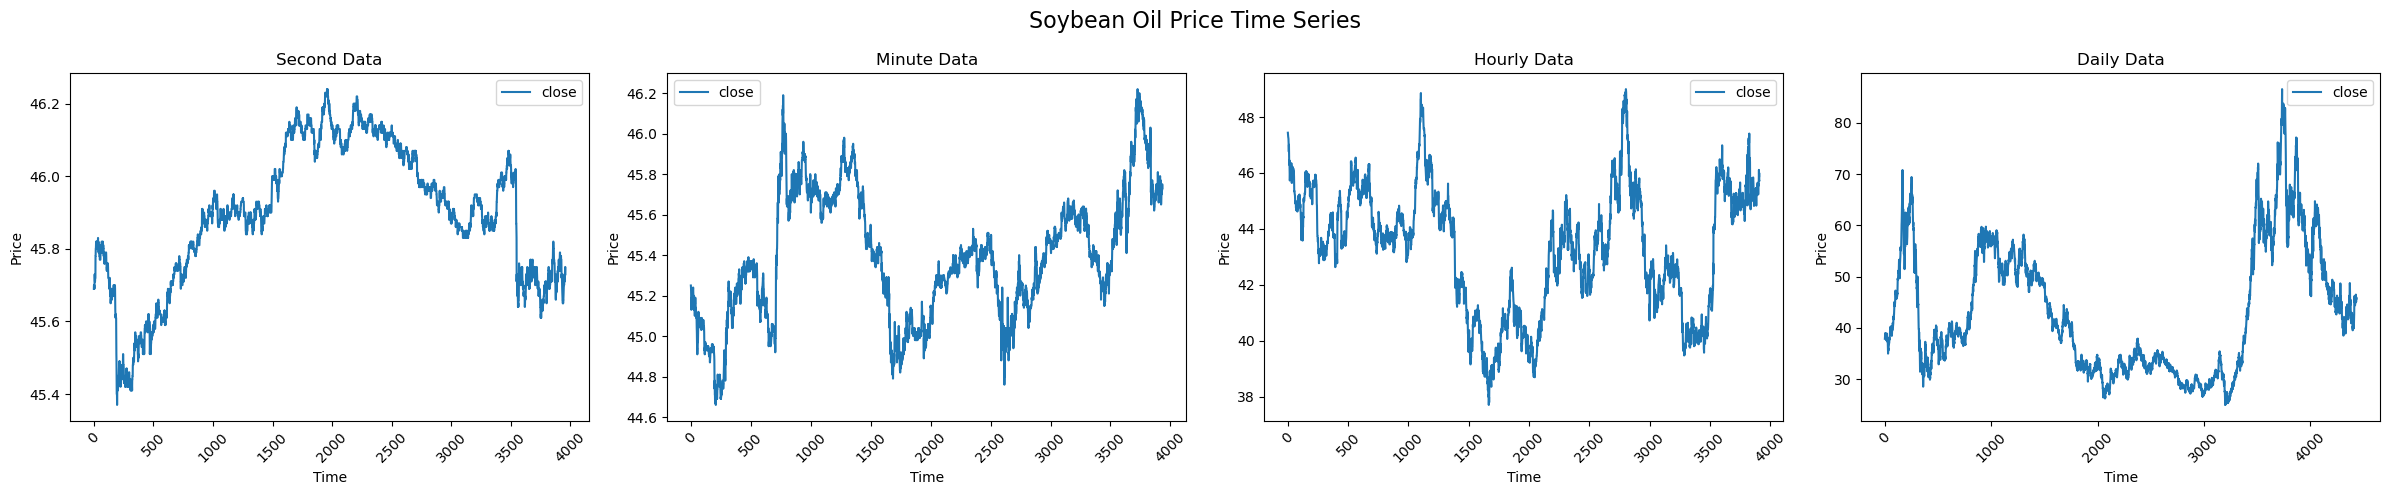

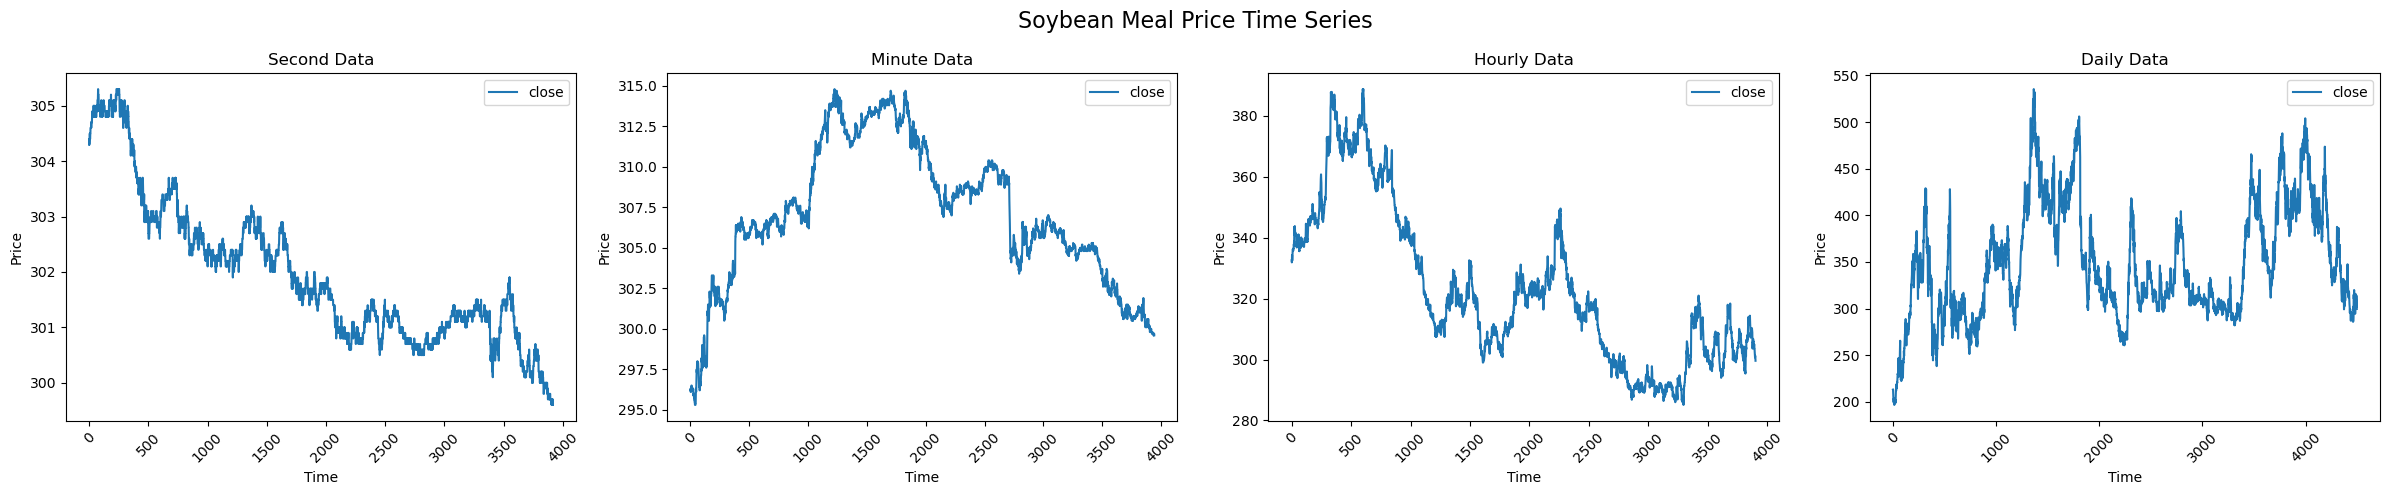

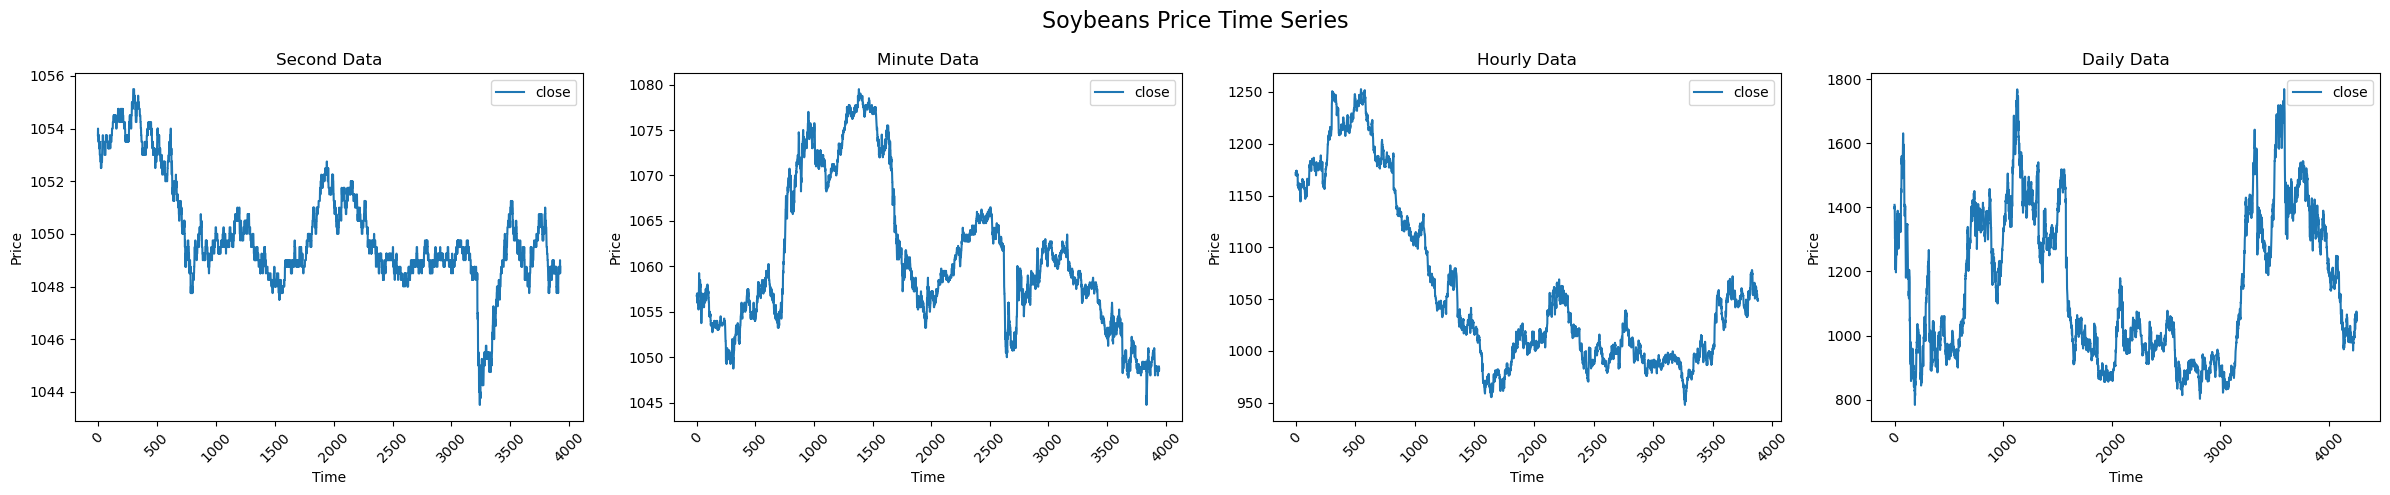

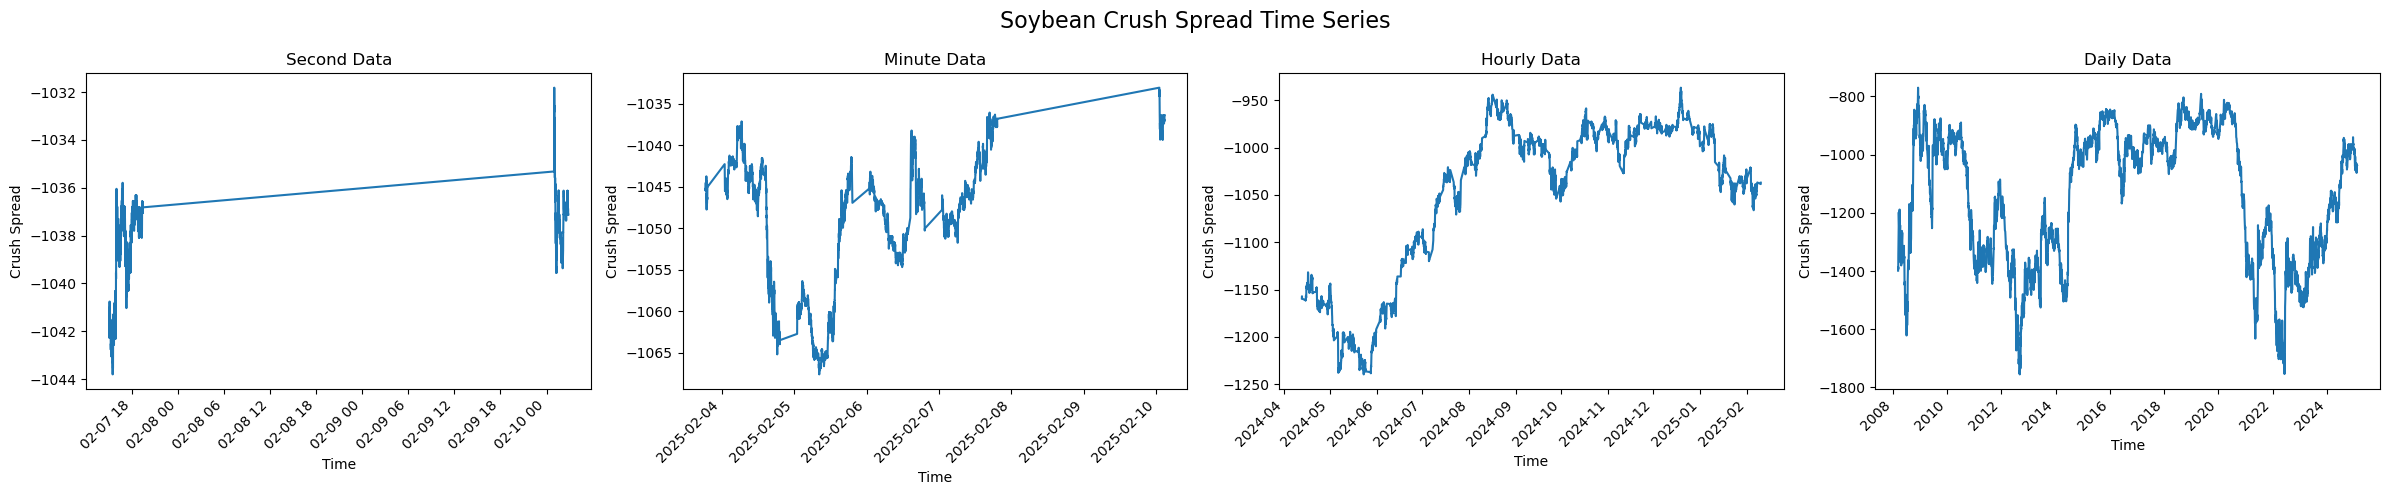

In [9]:
# Loading and processing the data
soy_oil_day, soy_oil_hour, soy_oil_min, soy_oil_sec, \
soy_meal_day, soy_meal_hour, soy_meal_min, soy_meal_sec, \
soy_beans_day, soy_beans_hour, soy_beans_min, soy_beans_sec = load_and_process_soybean_data(base_path)

# Calculating crush spreads
crush_spread_day, crush_spread_hour, crush_spread_min, crush_spread_sec = crush_spread_calculations_per_data_time(
    soy_beans_day, soy_meal_day, soy_oil_day,
    soy_beans_hour, soy_meal_hour, soy_oil_hour,
    soy_beans_min, soy_meal_min, soy_oil_min,
    soy_beans_sec, soy_meal_sec, soy_oil_sec
)

# Now call the plotting functions
plot_all_commodities(soy_oil_sec, soy_oil_min, soy_oil_hour, soy_oil_day,
                    soy_meal_sec, soy_meal_min, soy_meal_hour, soy_meal_day,
                    soy_beans_sec, soy_beans_min, soy_beans_hour, soy_beans_day)

plot_all_crush_spreads(crush_spread_sec, crush_spread_min, crush_spread_hour, crush_spread_day)

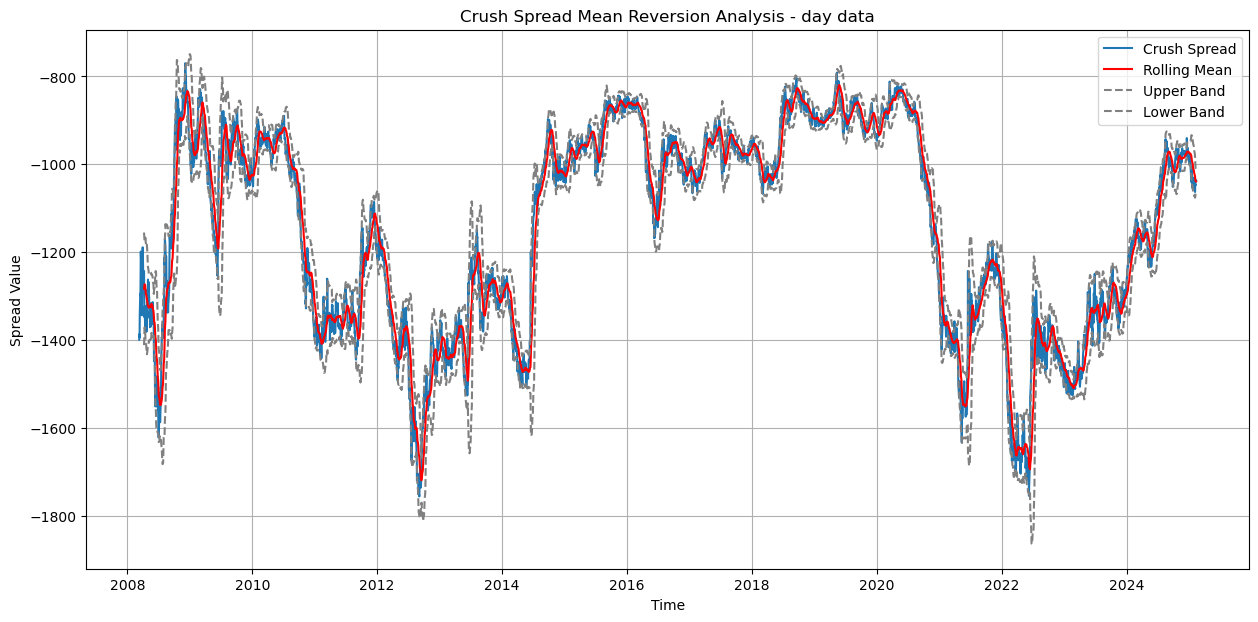


ADF Test Results for day data:
ADF Statistic: -2.691221021782239
p-value: 0.075569774830977
Critical values:
	1%: -3.4318856122567074
	5%: -2.8622185486666925
	10%: -2.567131196722582

Mean Reversion Statistics:
Mean: -1141.9958
Standard Deviation: 230.1717
Coefficient of Variation: 0.2016


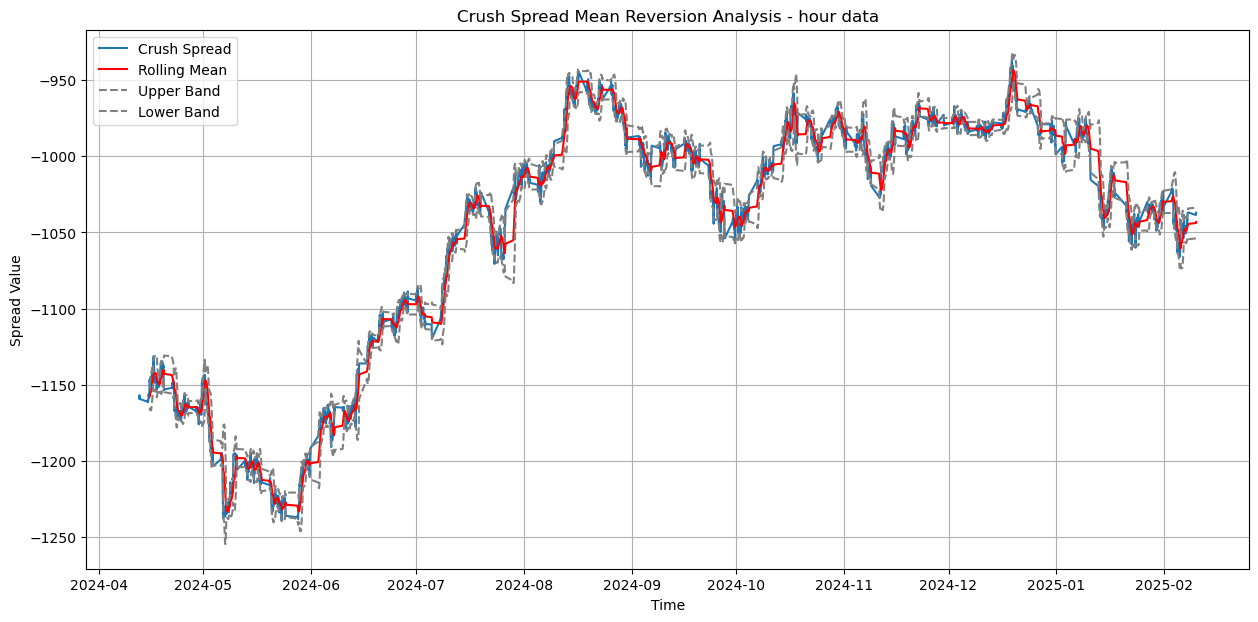


ADF Test Results for hour data:
ADF Statistic: -1.4896655978979685
p-value: 0.5386172847838505
Critical values:
	1%: -3.4320365029806847
	5%: -2.862285204612578
	10%: -2.567166681435328

Mean Reversion Statistics:
Mean: -1048.7289
Standard Deviation: 81.5568
Coefficient of Variation: 0.0778


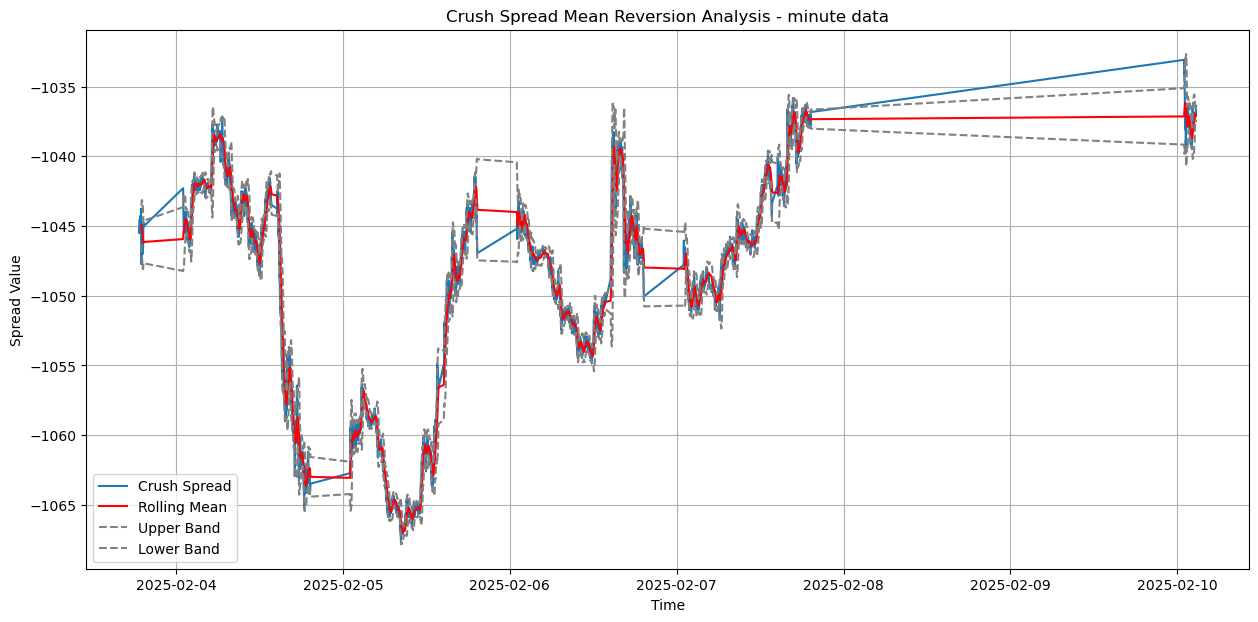


ADF Test Results for minute data:
ADF Statistic: -1.2288727123401
p-value: 0.6610537422522716
Critical values:
	1%: -3.4320150321602574
	5%: -2.8622757200880744
	10%: -2.5671616322540127

Mean Reversion Statistics:
Mean: -1049.1553
Standard Deviation: 8.0537
Coefficient of Variation: 0.0077


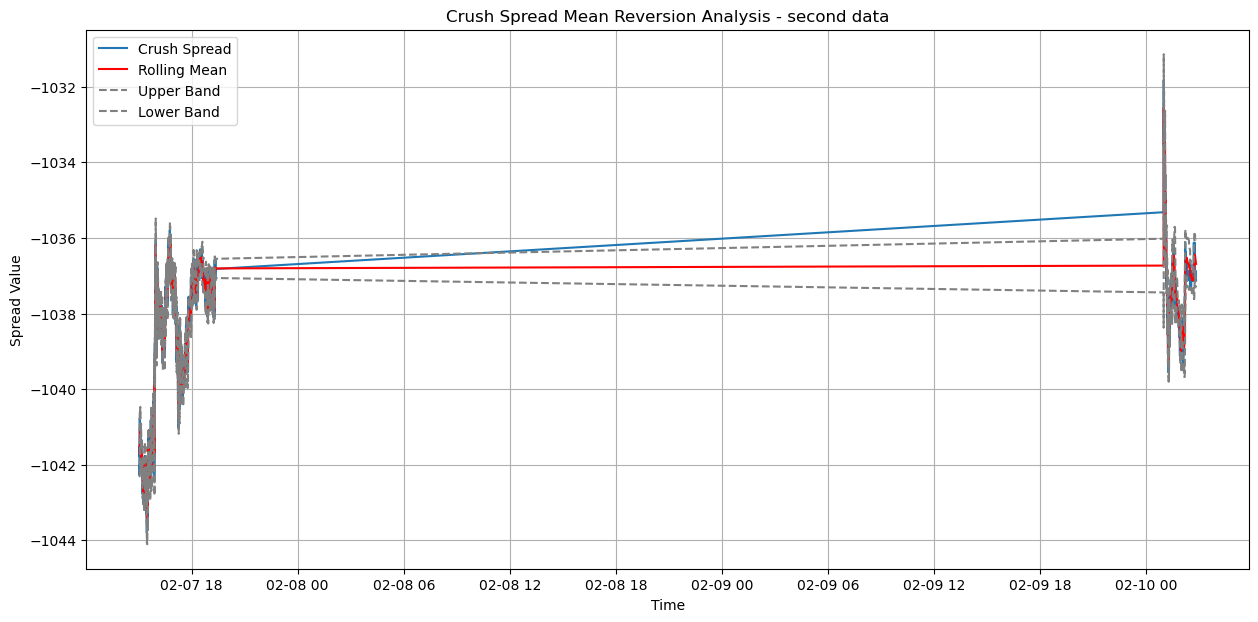


ADF Test Results for second data:
ADF Statistic: -2.545198550878585
p-value: 0.10486064151280405
Critical values:
	1%: -3.4320231263589913
	5%: -2.862279295629063
	10%: -2.567163535727597

Mean Reversion Statistics:
Mean: -1038.3422
Standard Deviation: 2.0430
Coefficient of Variation: 0.0020


In [ ]:
def test_mean_reversion(spread_data, timeframe):
    """
    Test for mean reversion in the crush spread
    
    Parameters:
    spread_data: DataFrame with crush spread
    timeframe: string indicating the data frequency ('day', 'hour', 'minute', 'second')
    """
    # 1. Perform ADF test
    adf_result = adfuller(spread_data['crush_spread'].dropna())
    
    # 2. Calculate rolling statistics
    rolling_mean = spread_data['crush_spread'].rolling(window=20).mean()
    rolling_std = spread_data['crush_spread'].rolling(window=20).std()
    
    # 3. Plot the spread with its rolling mean and std
    plt.figure(figsize=(15, 7))
    plt.plot(spread_data.index, spread_data['crush_spread'], label='Crush Spread')
    plt.plot(spread_data.index, rolling_mean, label='Rolling Mean', color='red')
    plt.plot(spread_data.index, rolling_mean + 2*rolling_std, label='Upper Band', color='gray', linestyle='--')
    plt.plot(spread_data.index, rolling_mean - 2*rolling_std, label='Lower Band', color='gray', linestyle='--')
    
    plt.title(f'Crush Spread Mean Reversion Analysis - {timeframe} data')
    plt.xlabel('Time')
    plt.ylabel('Spread Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 4. Print ADF test results
    print(f'\nADF Test Results for {timeframe} data:')
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    print('Critical values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value}')
    
    spread_mean = spread_data['crush_spread'].mean()
    spread_std = spread_data['crush_spread'].std()
    
    print(f'\nMean Reversion Statistics:')
    print(f'Mean: {spread_mean:.4f}')
    print(f'Standard Deviation: {spread_std:.4f}')
    print(f'Coefficient of Variation: {spread_std/abs(spread_mean):.4f}')

timeframes = {
    'day': crush_spread_day,
    'hour': crush_spread_hour,
    'minute': crush_spread_min,
    'second': crush_spread_sec
}

for timeframe, data in timeframes.items():
    test_mean_reversion(data, timeframe)


Stationarity Analysis for Daily

ADF Test:
ADF Statistic: -2.691221021782239
p-value: 0.075569774830977

KPSS Test:
KPSS Statistic: 0.76206894486189
p-value: 0.01


/Users/freddiekiessling/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


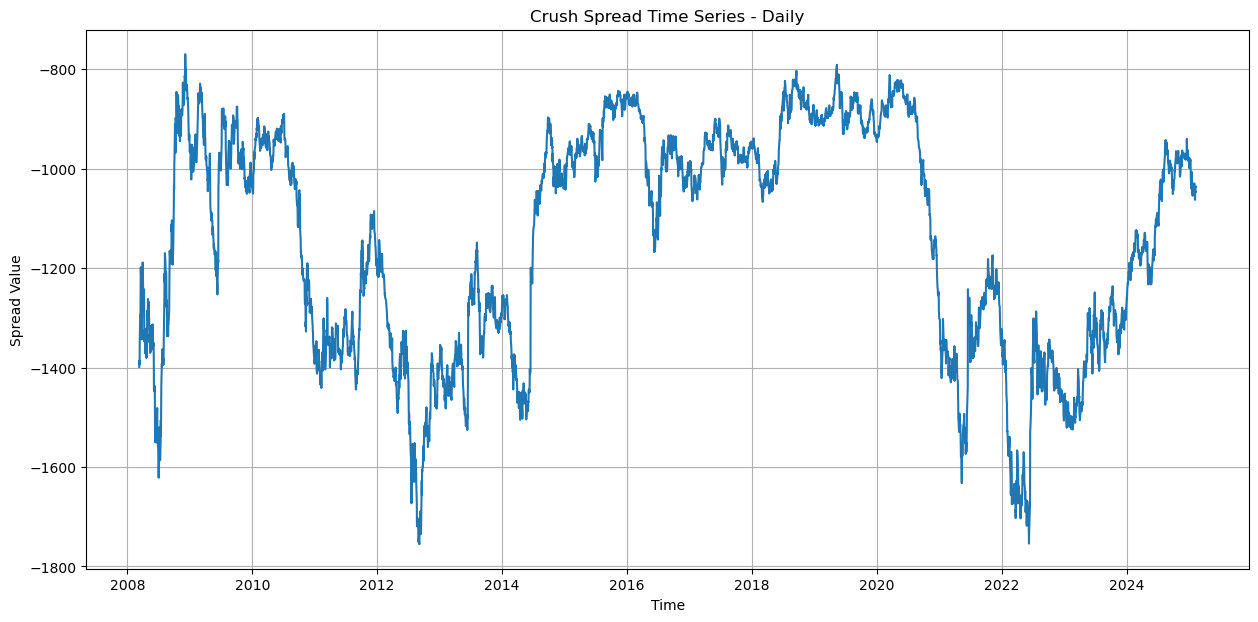


Stationarity Analysis for Hourly

ADF Test:
ADF Statistic: -1.4896655978979685
p-value: 0.5386172847838505

KPSS Test:
KPSS Statistic: 6.37419306449044
p-value: 0.01


/Users/freddiekiessling/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


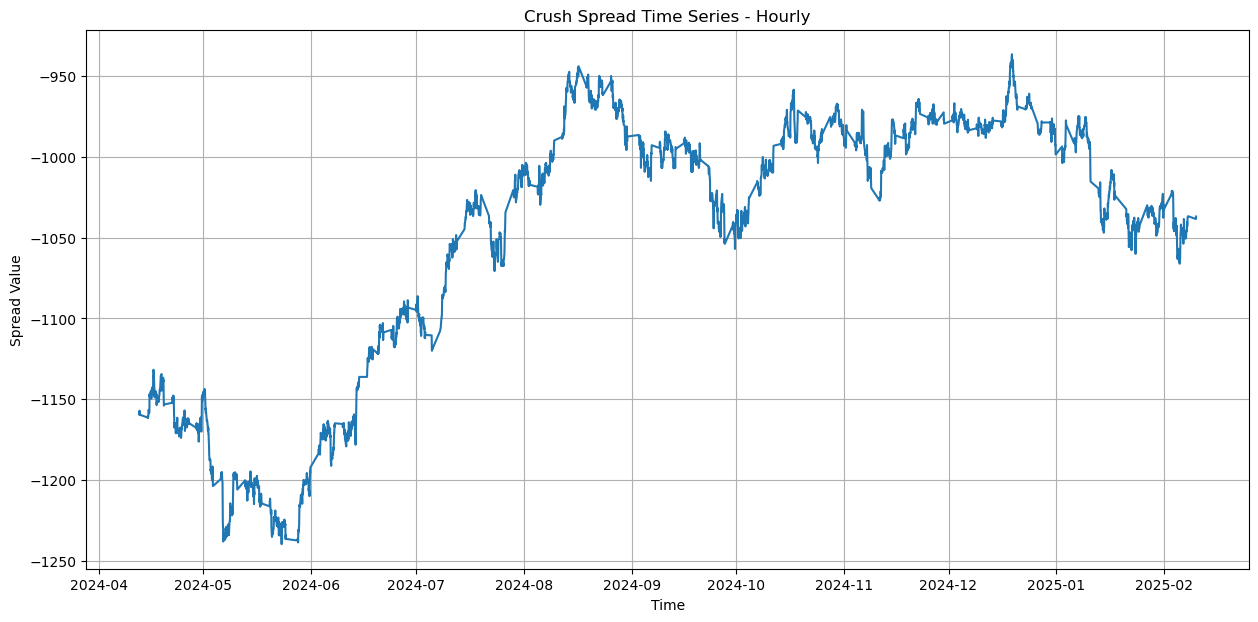


Stationarity Analysis for Minute

ADF Test:
ADF Statistic: -1.2288727123401
p-value: 0.6610537422522716

KPSS Test:
KPSS Statistic: 2.269746044444921
p-value: 0.01


/Users/freddiekiessling/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


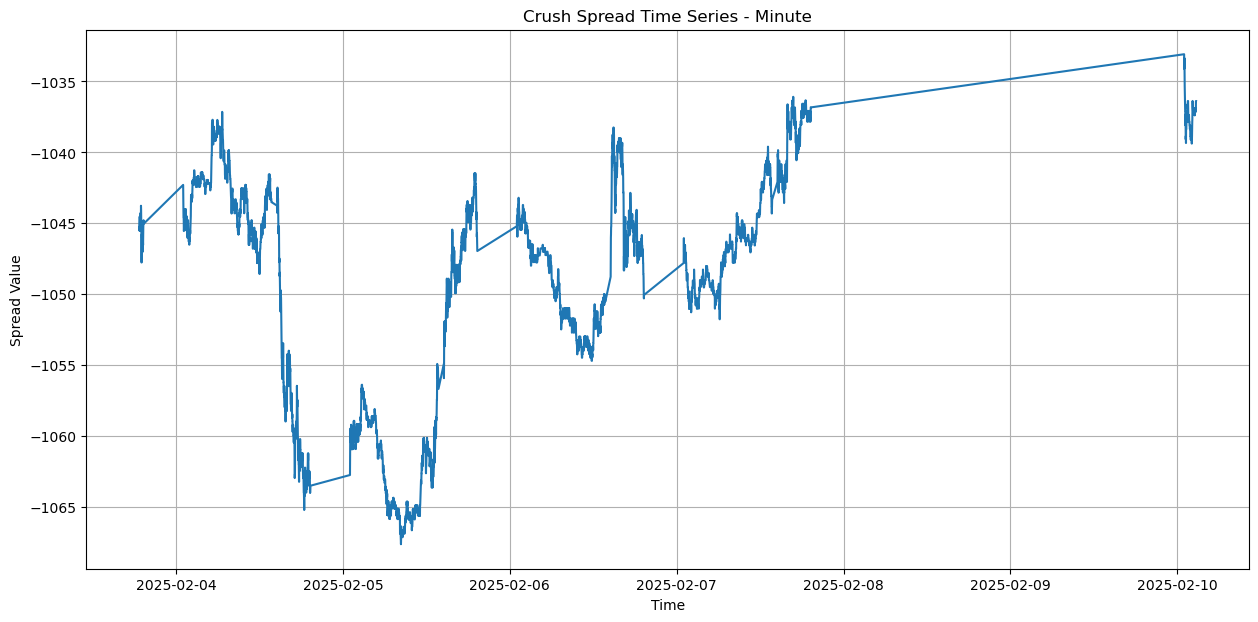


Stationarity Analysis for Second

ADF Test:
ADF Statistic: -2.545198550878585
p-value: 0.10486064151280405

KPSS Test:
KPSS Statistic: 4.332949102527749
p-value: 0.01


/Users/freddiekiessling/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


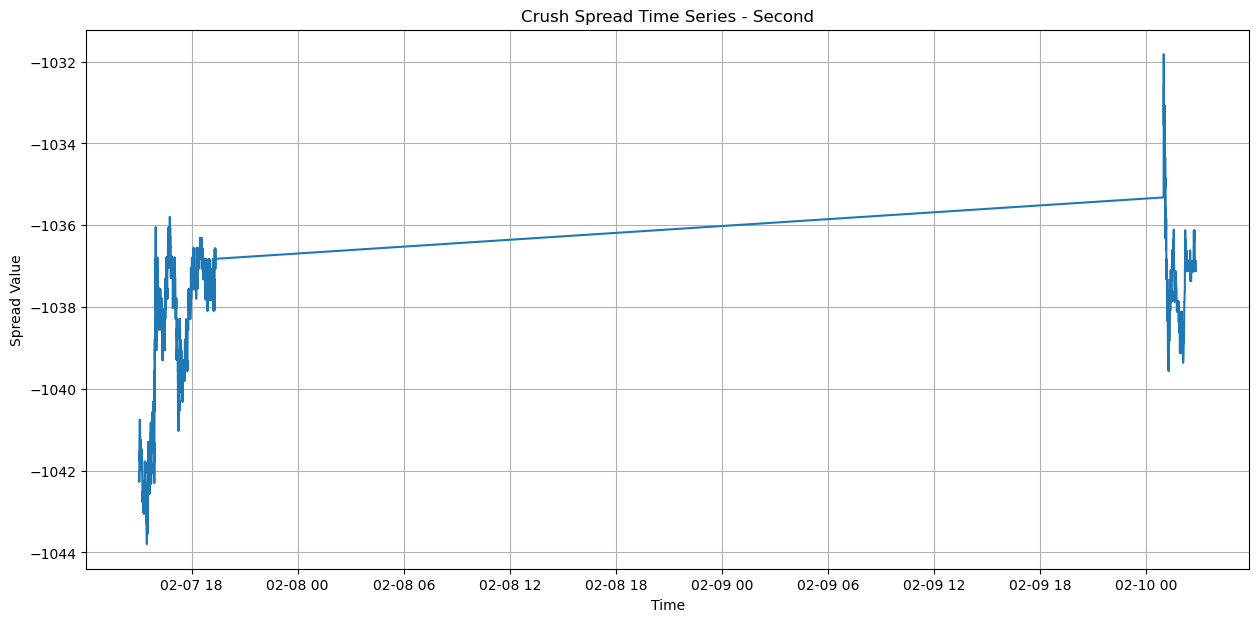

In [ ]:
def comprehensive_stationarity_tests(data, title=""):
    """
    Perform both ADF and KPSS tests for stationarity
    """
    print(f"\nStationarity Analysis for {title}")
    
    adf_result = adfuller(data['crush_spread'].dropna())
    print("\nADF Test:")
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')
    
    kpss_result = kpss(data['crush_spread'].dropna())
    print("\nKPSS Test:")
    print(f'KPSS Statistic: {kpss_result[0]}')
    print(f'p-value: {kpss_result[1]}')
    plt.figure(figsize=(15, 7))
    plt.plot(data.index, data['crush_spread'])
    plt.title(f'Crush Spread Time Series - {title}')
    plt.xlabel('Time')
    plt.ylabel('Spread Value')
    plt.grid(True)
    plt.show()

timeframes = {
    'Daily': crush_spread_day,
    'Hourly': crush_spread_hour,
    'Minute': crush_spread_min,
    'Second': crush_spread_sec
}

for name, data in timeframes.items():
    comprehensive_stationarity_tests(data, name)

In [18]:
def perform_johansen_test(soy_beans, soy_meal, soy_oil, timeframe):
    """
    Perform Johansen cointegration test with corrected attribute names
    """
    # Convert time columns to datetime
    soy_beans['time'] = pd.to_datetime(soy_beans['time'])
    soy_meal['time'] = pd.to_datetime(soy_meal['time'])
    soy_oil['time'] = pd.to_datetime(soy_oil['time'])
    
    # Create individual dataframes with time as index
    df_beans = soy_beans.set_index('time')['close']
    df_meal = soy_meal.set_index('time')['close']
    df_oil = soy_oil.set_index('time')['close']
    
    # Merge the dataframes
    df = pd.concat([df_beans, df_meal, df_oil], axis=1)
    df.columns = ['beans', 'meal', 'oil']
    df = df.dropna()
    
    print(f"\nData Check for {timeframe}:")
    print(f"Original shapes: Beans {len(soy_beans)}, Meal {len(soy_meal)}, Oil {len(soy_oil)}")
    print(f"After alignment shape: {df.shape}")
    
    # Convert to matrix for Johansen test
    data = df.values
    
    try:
        # Perform Johansen test
        result = coint_johansen(data, det_order=0, k_ar_diff=1)
        
        print(f"\nJohansen Cointegration Test Results for {timeframe} data:")
        print("===================================================")
        print("\nTrace Statistics:")
        print(f"r = 0: {result.trace_stat[2]:.4f}")  # Testing no cointegration
        print(f"r ≤ 1: {result.trace_stat[1]:.4f}")  # Testing at most one cointegration relationship
        print(f"r ≤ 2: {result.trace_stat[0]:.4f}")  # Testing at most two cointegration relationships
        
        print("\nCritical Values (95%):")
        print(f"r = 0: {result.cvm[2,1]:.4f}")
        print(f"r ≤ 1: {result.cvm[1,1]:.4f}")
        print(f"r ≤ 2: {result.cvm[0,1]:.4f}")
        
        # Interpretation
        print("\nInterpretation:")
        for i, trace_stat in enumerate(reversed(result.trace_stat)):
            if trace_stat > result.cvm[-(i+1),1]:
                print(f"Reject H0 of r ≤ {i} cointegrating relationships")
            else:
                print(f"Fail to reject H0 of r ≤ {i} cointegrating relationships")
                
    except Exception as e:
        print(f"Error performing Johansen test: {str(e)}")

# Test each timeframe
timeframes = {
    'Daily': (soy_beans_day, soy_meal_day, soy_oil_day),
    'Hourly': (soy_beans_hour, soy_meal_hour, soy_oil_hour),
    'Minute': (soy_beans_min, soy_meal_min, soy_oil_min),
    'Second': (soy_beans_sec, soy_meal_sec, soy_oil_sec)
}

for name, (beans, meal, oil) in timeframes.items():
    perform_johansen_test(beans, meal, oil, name)


Data Check for Daily:
Original shapes: Beans 4262, Meal 4498, Oil 4435
After alignment shape: (4262, 3)

Johansen Cointegration Test Results for Daily data:

Trace Statistics:
r = 0: 5.4598
r ≤ 1: 23.3824
r ≤ 2: 44.5041

Critical Values (95%):
r = 0: 3.8415
r ≤ 1: 14.2639
r ≤ 2: 21.1314

Interpretation:
Reject H0 of r ≤ 0 cointegrating relationships
Reject H0 of r ≤ 1 cointegrating relationships
Reject H0 of r ≤ 2 cointegrating relationships

Data Check for Hourly:
Original shapes: Beans 3881, Meal 3904, Oil 3911
After alignment shape: (3881, 3)

Johansen Cointegration Test Results for Hourly data:

Trace Statistics:
r = 0: 2.7337
r ≤ 1: 12.2441
r ≤ 2: 26.1986

Critical Values (95%):
r = 0: 3.8415
r ≤ 1: 14.2639
r ≤ 2: 21.1314

Interpretation:
Fail to reject H0 of r ≤ 0 cointegrating relationships
Fail to reject H0 of r ≤ 1 cointegrating relationships
Reject H0 of r ≤ 2 cointegrating relationships

Data Check for Minute:
Original shapes: Beans 3945, Meal 3943, Oil 3934
After alignment

In [ ]:
'''
Project Flow:
a) spread calculation
	Crush Spread = (Soybean Meal × 0.022 + Soybean Oil × 0.11) - Soybeans
b) stationary-tests:
	b) i) ADF Test:
		Daily:    p = 0.076 (almost stationary)
		Hourly:   p = 0.539 (non-stationary)
		Minute:   p = 0.661 (non-stationary)
		Second:   p = 0.105 (non-stationary)

		adress questions of time frames stationary why not stationary at some points? true at every time resolution?

		ii) KPSS Test:
		Daily:    KPSS Statistic = 0.762 (closest stationary)
		Hourly:   KPSS Statistic = 6.374 (non-stationary)
		Minute:   KPSS Statistic = 2.269 (non-stationary)
		Second:   KPSS Statistic = 4.332 (non-stationary)

		- Both tests agree: series is mostly non-stationary
		- Daily data shows most promise for stationarity
		- Higher frequencies (hour/minute/second) more non-stationary

	- jump tests	
goodness of fit tests
kurtosesis

volatility of each spread in terms


c) Johansen Test (checking if the 3 series move together long term)
	    i)  Daily:    Trace Stats > Critical Values (cointegrated)
                 r = 0:  5.4598 > 3.8415
                 r ≤ 1: 23.3824 > 14.2639
                 r ≤ 2: 44.5041 > 21.1314

    		Hourly:  No cointegration found
                 Failed to reject all H0s

    		Minute: No cointegration found
                 Failed to reject all H0s

    		Second:  No cointegration found
                 Failed to reject all H0s

d)

'''

In [ ]:
'''
In simple:

1. ADF Test (Augmented Dickey-Fuller):
	What it Tests: Does the series wander or return to a mean?
	Results:
	- Daily (p=0.076): Almost returns to mean
	- Others (p>0.05): Wanders without pattern

2. KPSS Test (Kwiatkowski-Phillips-Schmidt-Shin):

	What it Tests: Same as ADF but opposite perspective
	Results:
	- Daily (0.762): Most stable
	- Others (>2.0): Very unstable

3. Johansen Test:
	What it Tests: Do multiple series move together?
	Results:
	- Daily: All 3 series move together
	- Others: No clear relationship

	Like checking: Do three friends walk together or randomly?

Cointegration Means:
	- Series can wander individually
	- BUT they don't wander far from each other
	- Like three dogs on separate leashes:
	* Each can move freely
	* But can't get too far from others

	
	seasonal patterns decompose & volatility
	non-stationary in a pattern 

	time sereis plots for january after january 

4. maybe?

	ARCH Test: 
	- Like checking if stormy weather comes in clusters
	- Example: One big price move often leads to more big moves
	- Think: "After a crazy day in the market, do more crazy days follow?"

	GARCH:
	- Like a weather forecast for market turbulence
	- Predicts if tomorrow will be calm or volatile
	- Think: "If today was stormy, will tomorrow be stormy too?"

'''

In [19]:
from arch import arch_model
import numpy as np
from statsmodels.stats.diagnostic import het_arch

def perform_volatility_analysis(data, timeframe='Daily'):
    returns = data['crush_spread'].diff().dropna()
    
    print(f"\nVolatility Analysis for {timeframe} Data")
    print("=====================================")
    
    # 1. ARCH Test
    arch_test = het_arch(returns)
    print("\nARCH Test Results:")
    print(f"LM Statistic: {arch_test[0]:.4f}")
    print(f"P-value: {arch_test[1]:.4f}")
    print(f"Volatility Clustering: {'Yes' if arch_test[1] < 0.05 else 'No'}")
    # 2. GARCH Model
    print("\nGARCH(1,1) Model Results:")
    try:
        model = arch_model(returns, vol='GARCH', p=1, q=1)
        results = model.fit(disp='off')
        print("\nParameter Estimates:")
        print(f"Omega (constant): {results.params['omega']:.6f}")
        print(f"Alpha (ARCH): {results.params['alpha[1]']:.6f}")
        print(f"Beta (GARCH): {results.params['beta[1]']:.6f}")
        persistence = results.params['alpha[1]'] + results.params['beta[1]']
        print(f"\nVolatility Persistence: {persistence:.4f}")
        print(f"{'High' if persistence > 0.9 else 'Moderate' if persistence > 0.5 else 'Low'} persistence")
        forecast = results.forecast()
        print(f"\nNext Period Volatility Forecast: {np.sqrt(forecast.variance.values[-1]):.6f}")
    except Exception as e:
        print(f"Error in GARCH modeling: {str(e)}")
perform_volatility_analysis(crush_spread_day)


Volatility Analysis for Daily Data

ARCH Test Results:
LM Statistic: 70.4441
P-value: 0.0000
Volatility Clustering: Yes

GARCH(1,1) Model Results:

Parameter Estimates:
Omega (constant): 2.056343
Alpha (ARCH): 0.082238
Beta (GARCH): 0.917762

Volatility Persistence: 1.0000
High persistence
Error in GARCH modeling: unsupported format string passed to numpy.ndarray.__format__


In [ ]:
'''


1. ARCH Test:
   LM Statistic: 70.4441
   P-value: <0.0001 
   What it means:
   - Tests if volatility comes in clusters
   - Very high LM stat (70.4) = strong clustering
   - P-value = close to 0 means definitely not random clustering

2. GARCH(1,1) Model:
   The (1,1) means:
   - Look 1 period back for shocks (ARCH term)
   - Look 1 period back for old volatility (GARCH term)

   Parameters tell us:
   Omega (2.056): Base volatility when market calm
   Alpha (0.082): 8.2% of tomorrow's volatility comes from today's shock
   Beta (0.918): 91.8% comes from previous volatility pattern


3. Persistence = Alpha + Beta = 1.0000
   What this means:
   - Shocks never die out (usually concerning)
   - Market doesn't "forget" old volatility
   - Might need different model settings










Voltatility (market wildness):


1. Omega (2.056343) = Base Level
   - "normal" level of market movement
   - The default state when everything's calm
   
2. Alpha (0.082238) = Today's Impact
   - How much today's big move affects tomorrow
   - Small value (0.08) means today's shock has little effect
   - Only 8% of tomorrow's volatility comes from today
   
3. Beta (0.917762) = Memory Effect
   - How much old volatility carries forward
   - Large value (0.92) means past volatility really matters
   - 92% of tomorrow's volatility comes from the past

'''